<a href="https://colab.research.google.com/github/ttury/extrinsic-spin-hall-effect-simulation/blob/main/SFE_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [254]:
from math import sqrt
import numpy as np
from numpy.linalg import norm

k = 8.9876 * (10**9) # 쿨롱 상수
# mass_of_electron = 9.1093837 * (10**-31) # 전자 질량
mass_of_electron = 1e-3
elementary_charge = 1.6021773349 * (10**-19) # 기본 전하(전자, 양성자 1개의 전하량)
dt = 0.01
c = 299792458
dirac = 1.0545718 * (10**-34)

class Dot:
  def __init__(self, x, y, v, q, s):
    self.x = x # 스칼라
    self.y = y # 스칼라
    self.v = v # 2차원 벡터(vx, vy)
    self.q = q
    if s == 'up':
      self.s = sqrt(3) / 2 * dirac
    else:
      self.s = -sqrt(3) / 2 * dirac

class Field(Dot):
# 기본적으로 dot1은 전자, dot2는 불순물(원자)를 가리킴
  def __init__(self, dot1, dot2):
    self.dot1 = dot1
    self.dot2 = dot2
    self.distance_list = []
    self.potential_list = []
    self.dot1_x_list = []
    self.dot1_y_list = []
    self.dot1_x_list.append(dot1.x)
    self.dot1_y_list.append(dot1.y)
    self.distance_size = self.getDistance()
    self.distance_vector = self.getDistance_vector()
    self.velocity_vector = self.dot1.v
    self.velocity_size = norm(self.velocity_vector)
    self.sine_theta = self.getSine()
    self.cosine_theta = self.getCosine()

  def getDistance_vector(self):
    distance_vector = np.array([self.dot1.x - self.dot2.x, self.dot1.y - self.dot2.y])
    return distance_vector
  
  def getDistance(self):
    distance_vector = self.getDistance_vector()
    return norm(distance_vector)

  def getCosine(self):
    cosine = (self.dot1.x - self.dot2.x) / self.distance_size
    return cosine

  def getSine(self):
    sine = (self.dot1.y - self.dot2.y) / self.distance_size
    return sine

  # dot2(불순물)가 dot1(전자)에 가하는 쿨롱 척력 구하기
  def getCoulombForce(self):
    force_magnitude = self.getCoulombForce_magnitude()
    force_x = force_magnitude * self.cosine_theta
    force_y = force_magnitude * self.sine_theta
    force = np.array([force_x, force_y]) # 2차원 벡터 표현(Fx, Fy)
    # print('쿨롱 힘: {}', force)
    return force
  
  def getCoulombForce_magnitude(self):
    r = self.distance_size
    force_magnitude = k * (self.dot1.q * self.dot2.q) / r**2
    return force_magnitude
  
  # 쿨롱 퍼텐셜 에너지
  def getCoulombEnergy(self):
    r = self.distance_size
    potential = k * self.dot1.q * self.dot2.q / r
    return potential

  # 거리 벡터와 운동량 벡터의 사이각을 계산할 때 두 벡터의 좌우 관계를 구별하지 못했던 코사인의 한계 개선 -> 외적을 통한 사인
  def getSineBetweenTwoVectors(self, vector2D_1, vector2D_2):
    outer = vector2D_1[0] * vector2D_2[1] - vector2D_2[0] * vector2D_1[1] # 2차원 벡터 간 외적 공식 : (x1 - y2) * (x2 - y1)
    sine_alpha = outer / (norm(vector2D_1) * norm(vector2D_2))
    return sine_alpha # 기존에 사인 알파를 구했던 방법과 달라 거기에 맞추려고 마이너스 붙임

  def getOrbitMomentum(self):
    sine_alpha = self.getSineBetweenTwoVectors(self.distance_vector, self.velocity_vector)
    # 거리 벡터와 속도 벡터 사이각 구하기
    # 기존의 내적을 이용한 코사인 사이각은 거리 벡터에 대해 속도 벡터가 오른쪽에 있는지 왼쪽에 있는지 구분 못함
    # 외적을 이용한 사인 사이각 -> 한계 개선
    # 속도 벡터가 거리 벡터 오른쪽에 있으면 +, 왼쪽에 있으면 -를 가짐
    p_size = mass_of_electron * self.velocity_size # 충격량 스칼라
    p_vertical_size = p_size * sine_alpha  # 거리 벡터 r에 수직한 p의 성분만 사용함, 시계 방향 : +, 반시계 방향 : -
    # p_vertical_x = sine_theta * p_vertical_size # 수직방향 p의 크기를 다시 x성분과 y성분으로 나누기
    # p_vertical_y = -cosine_theta * p_vertical_size
    # p_vertical_vector = np.array([p_vertical_x, p_vertical_y])
    L = self.distance_size * p_vertical_size # p가 양수, 음수를 모두 가지므로 시계, 반시계 회전 정의 가능
    return L

  # 스핀 궤도 결합 퍼텐셜 에너지
  def getSOI(self):
    coulomb_force = self.getCoulombForce_magnitude() # dV/dr = V' = 쿨롱 힘 -> 같은 전하끼리 음수
    # cosine_alpha = np.dot(velocity_vector, distance_vector) / (velocity_size * distance_size) # 내적을 이용한 코사인 사이각
    # sine_alpha = sqrt(1 - cosine_alpha**2)
    L = self.getOrbitMomentum() # 궤도각운동량
    SOI_energy = (1 / (2 * mass_of_electron**2 * c**2 * self.distance_size)) * -coulomb_force * self.dot1.s * L
    # 어짜피 S와 L은 평행 또는 반평행이므로 벡터의 내적이 아닌 스칼라의 곱셈으로 정의함
    # S·L = |S|*|L|*cosθ 일 때 cosθ = -1 or 1이기 때문
    SOI_force_size = SOI_energy * (2/self.distance_size) # SOI_energy 식을 distance_size에 대해 편미분하면 이렇게 됨
    SOI_force_x = SOI_force_size * self.cosine_theta
    SOI_force_y = SOI_force_size * self.sine_theta
    SOI_force = np.array([SOI_force_x, SOI_force_y])
    return [SOI_energy, SOI_force]

  # 기본 아이디어 : 퍼텐셜 구하기 -> r(스칼라)에 대해 미분 -> 힘의 크기 -> sin, cos 곱함 -> 힘 벡터(Fx, Fy) 구하기
  def update(self):

    # 물리량 업데이트
    self.distance_size = self.getDistance()
    self.distance_vector = self.getDistance_vector()
    self.velocity_vector = self.dot1.v
    self.velocity_size = norm(self.velocity_vector)
    self.sine_theta = self.getSine()
    self.cosine_theta = self.getCosine()

    SOI_energy, SOI_force = self.getSOI()
    potential_energy = self.getCoulombEnergy() + SOI_energy # effective potential energy
    # net_force = self.getCoulombForce() + SOI_force*3.468 * 1e52  # 알짜힘 벡터, 1e53이 제일 좋음
    net_force = self.getCoulombForce() + SOI_force*1e53
    acceleration = net_force / mass_of_electron # 가속도 벡터
    self.dot1.v = self.dot1.v + acceleration * dt # v(t) = v(t-1) + a(t) * dt
    velocity_x, velocity_y = self.dot1.v
    dx, dy = velocity_x * dt, velocity_y * dt
    # print("dx = {}, dy = {}".format(dx, dy))
    self.dot1.x = self.dot1.x + dx  # x(t+1) = x(t) + vx(t)
    self.dot1.y = self.dot1.y + dy  # y(t+1) = y(t) + vy(t)

    # self.distance_list.append(self.distance_size)
    # self.potential_list.append(potential_energy)
    self.dot1_x_list.append(self.dot1.x)
    self.dot1_y_list.append(self.dot1.y)

In [ ]:
from numpy.linalg import norm
from math import sqrt

vector1 = [1, sqrt(3)]
vector2 = [sqrt(3), 1]

outer = (vector1[0] * vector2[1]) - (vector2[0] * vector1[1])
sine = outer / (norm(vector1) * norm(vector2))

print(sine)

-0.5


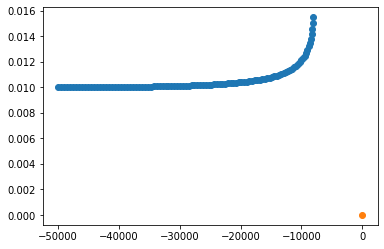

In [255]:


# electron = Dot(-200, 10, [100, 0], elementary_charge)
# impurity = Dot(0, 0, [0, 0], elementary_charge)
import matplotlib.pyplot as plt

electron = Dot(-50000, 0.01, [50000, 0], 1, 'up')
impurity = Dot(0, 0, [0, 0], 1, 'up')
field = Field(electron, impurity)

for i in range(0, int(1/dt)): # 0초 ~ n초까지 dt 간격으로 위치 표시
  field.update()

plt.scatter(field.dot1_x_list, field.dot1_y_list)
plt.scatter([0], [0])
plt.show()

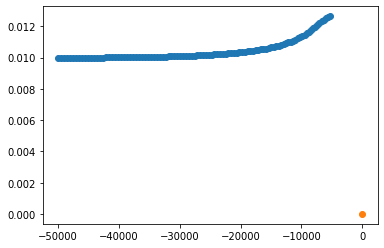

In [256]:
# electron = Dot(-200, 10, [100, 0], elementary_charge)
# impurity = Dot(0, 0, [0, 0], elementary_charge)
import matplotlib.pyplot as plt

electron = Dot(-50000, 0.01, [50000, 0], 1, 'down')
impurity = Dot(0, 0, [0, 0], 1, 'up')
field = Field(electron, impurity)

for i in range(0, int(1/dt)): # 0초 ~ n초까지 dt 간격으로 위치 표시
  field.update()

plt.scatter(field.dot1_x_list, field.dot1_y_list)
plt.scatter([0], [0])
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


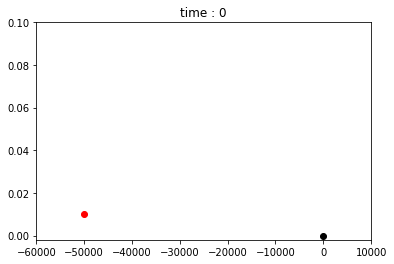

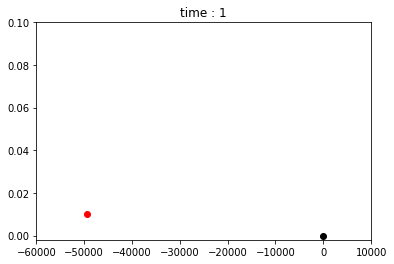

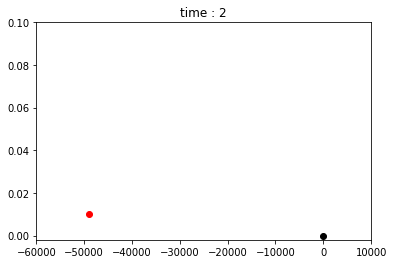

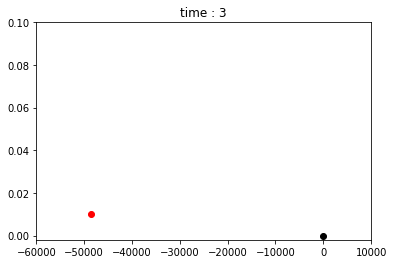

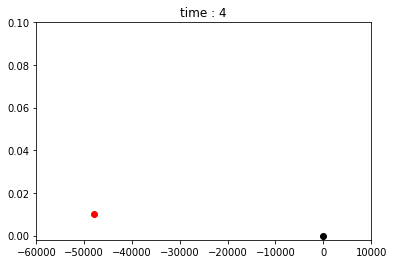

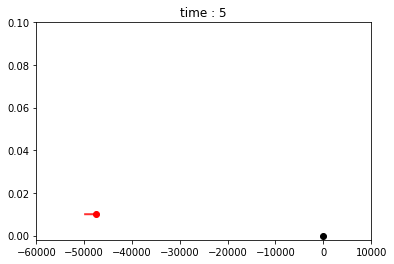

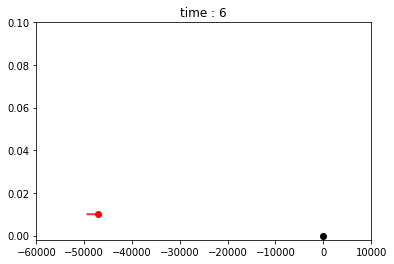

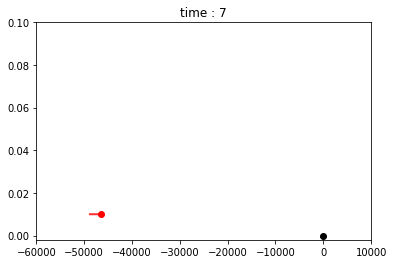

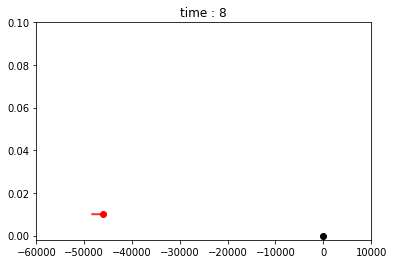

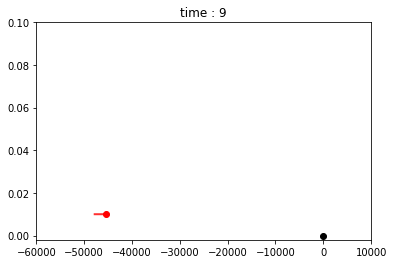

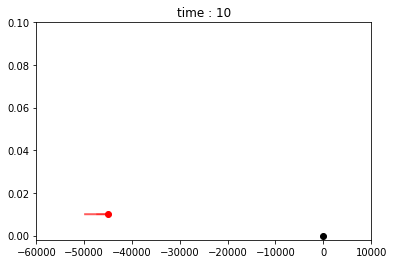

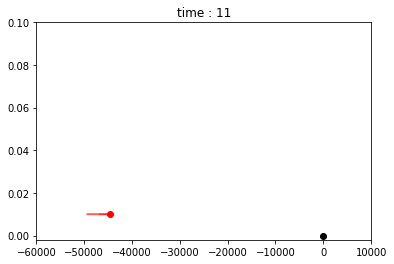

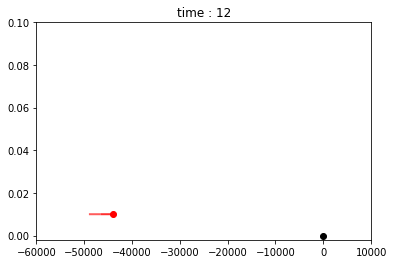

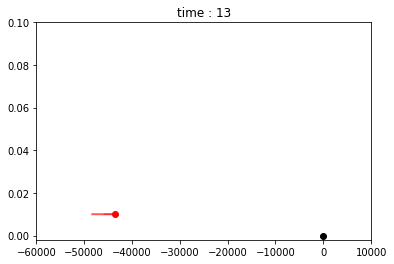

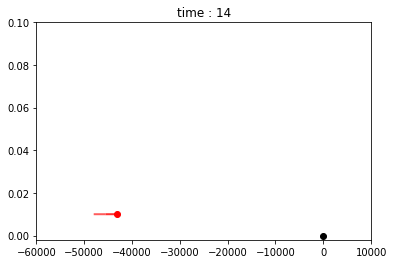

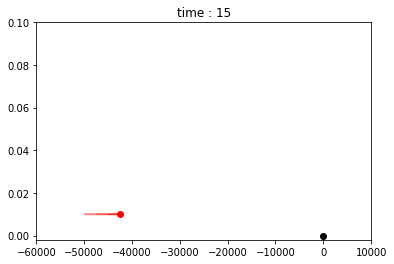

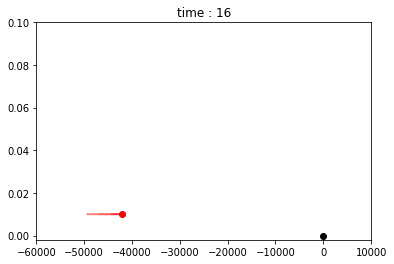

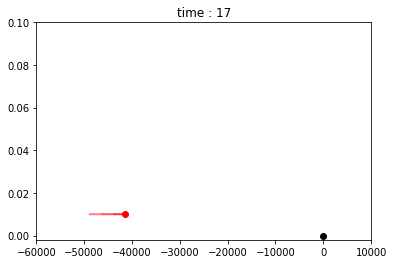

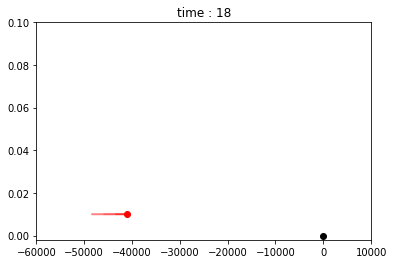

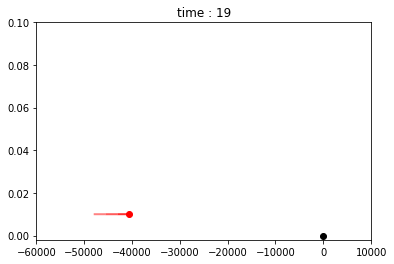

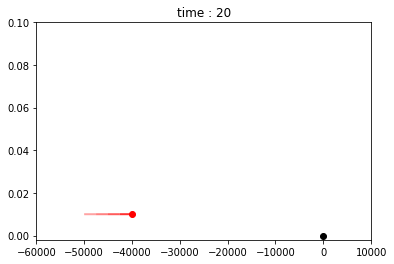

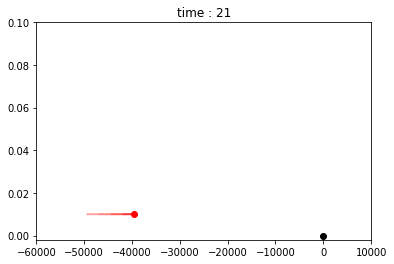

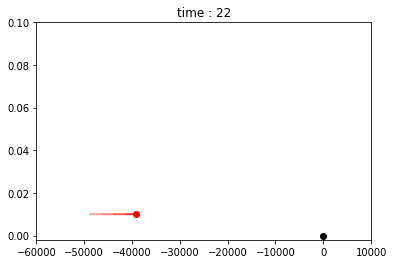

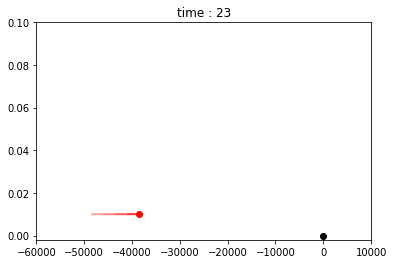

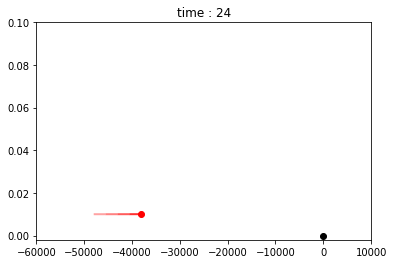

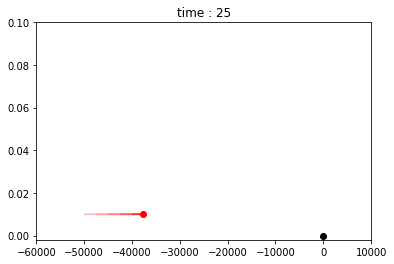

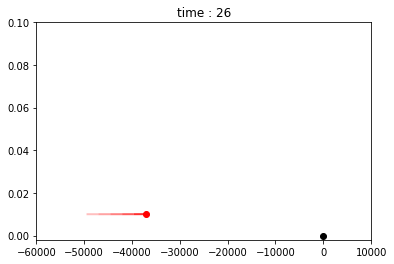

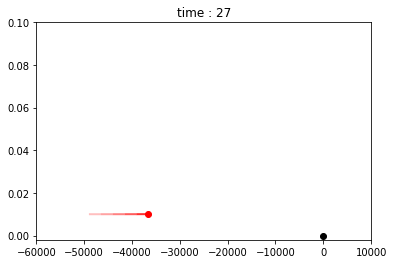

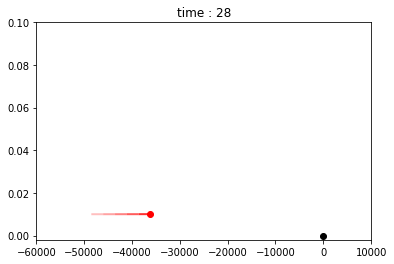

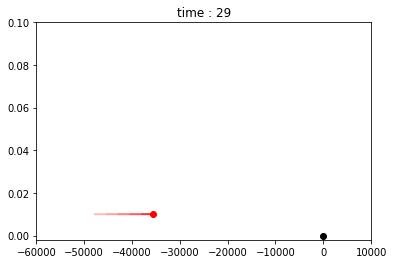

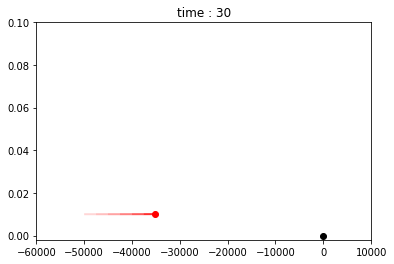

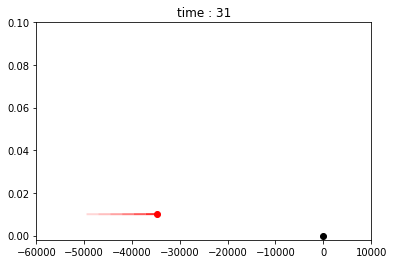

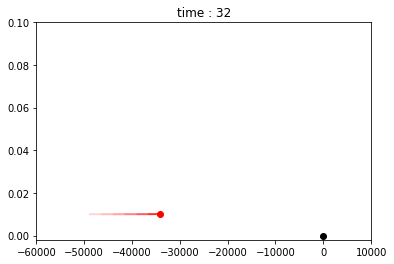

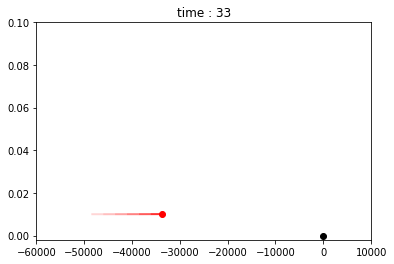

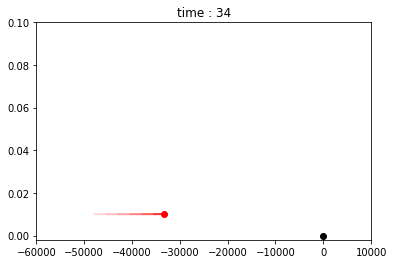

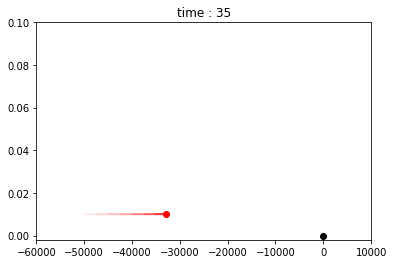

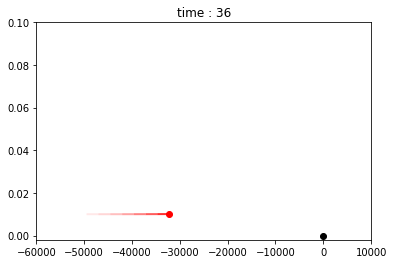

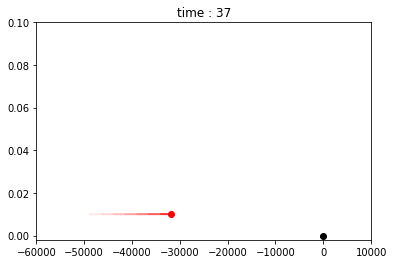

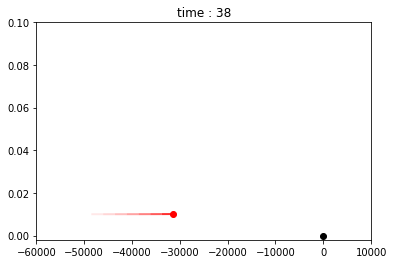

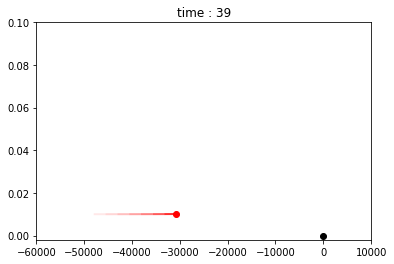

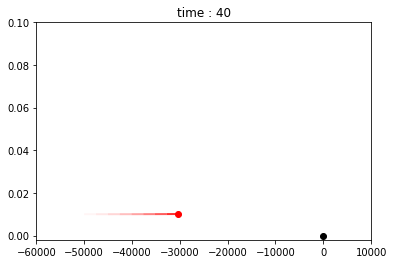

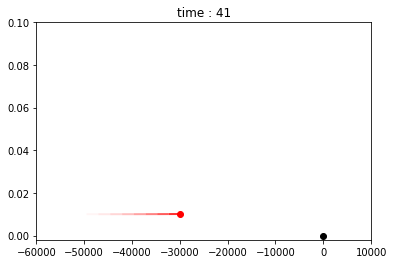

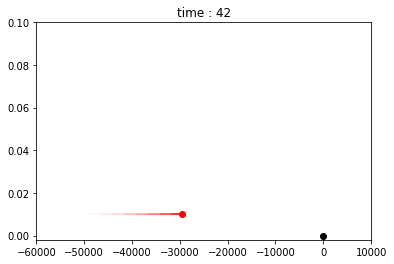

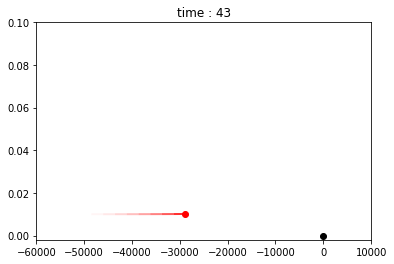

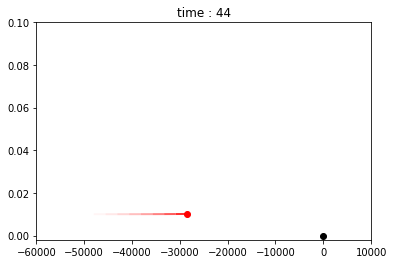

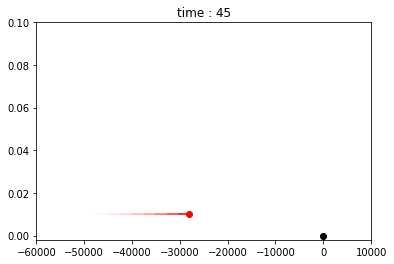

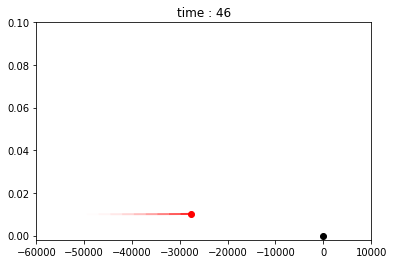

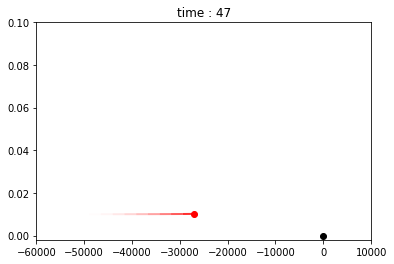

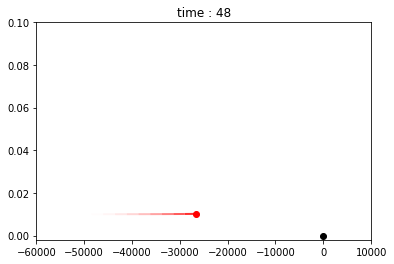

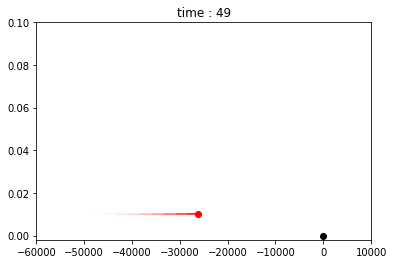

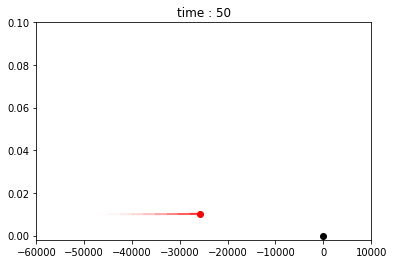

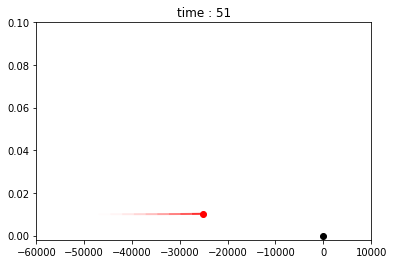

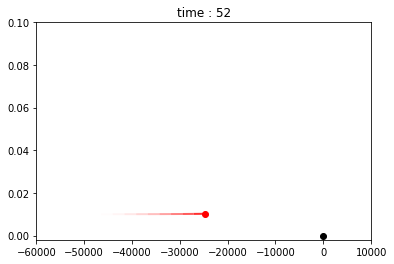

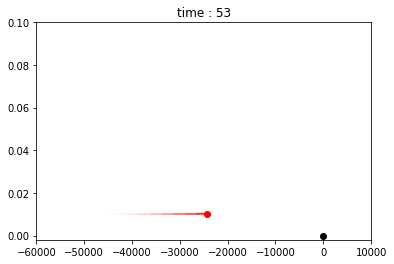

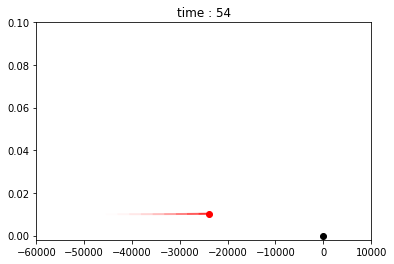

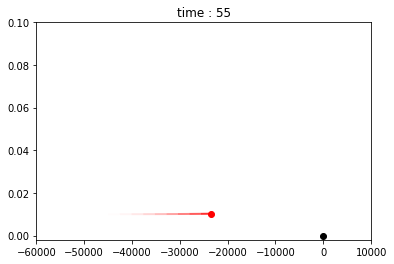

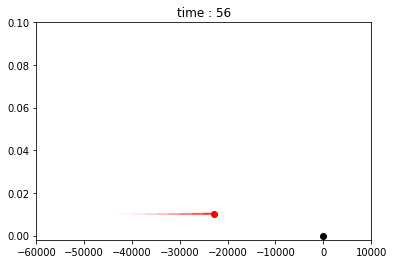

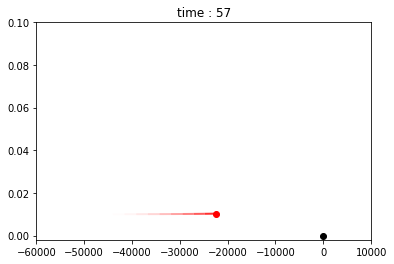

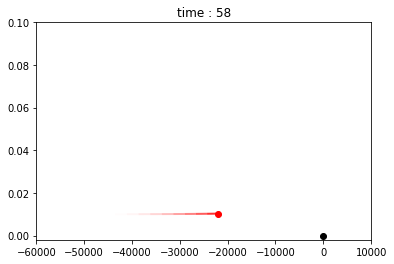

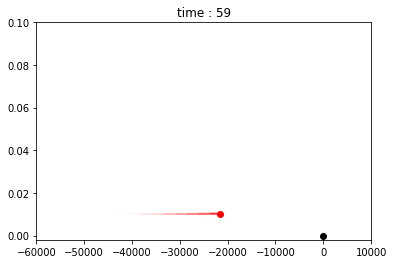

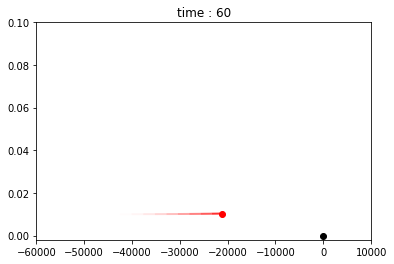

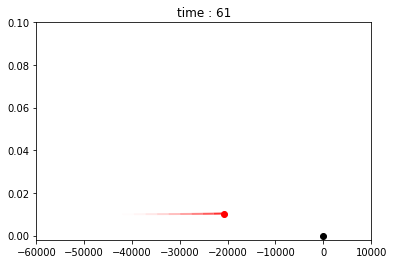

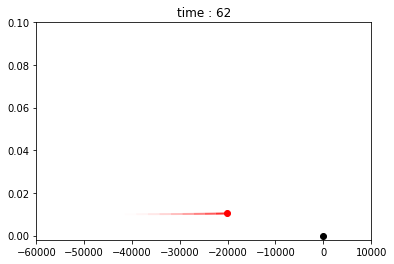

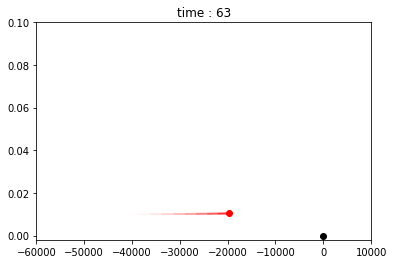

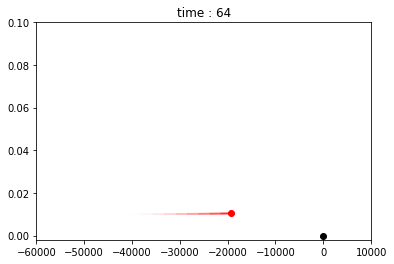

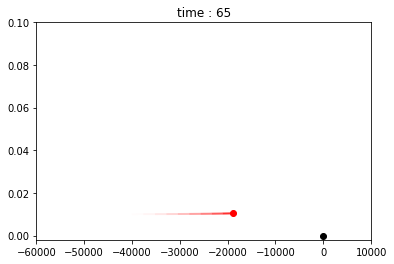

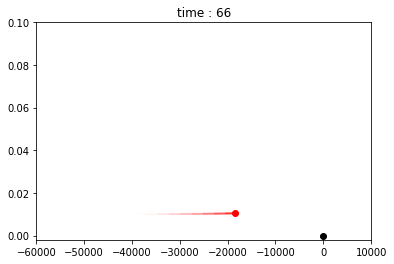

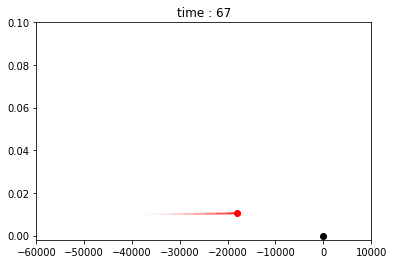

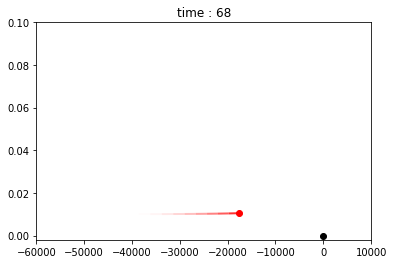

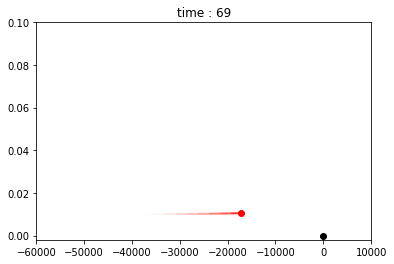

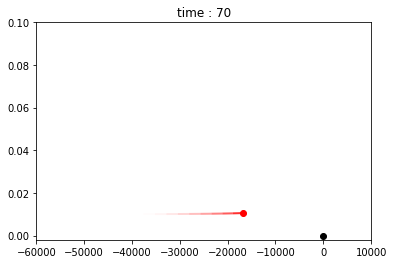

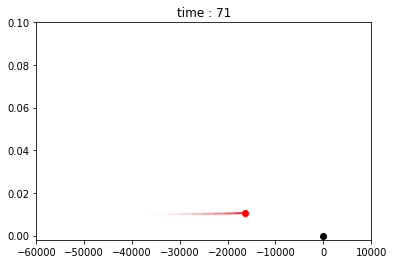

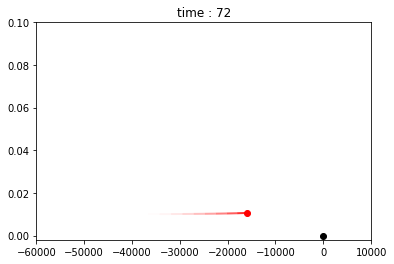

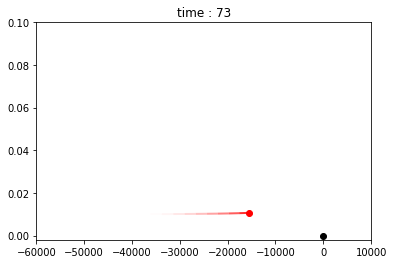

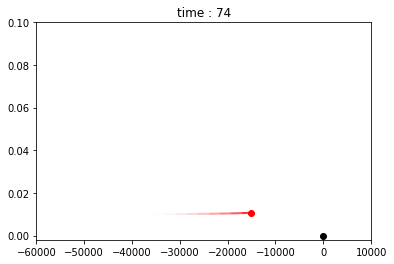

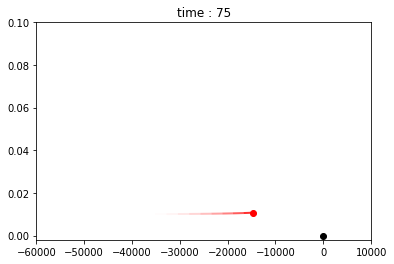

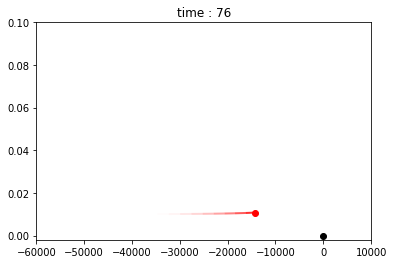

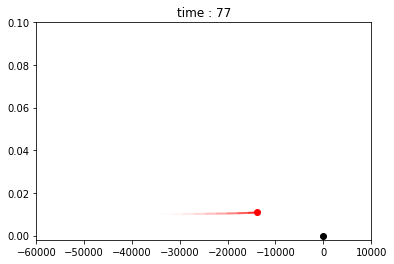

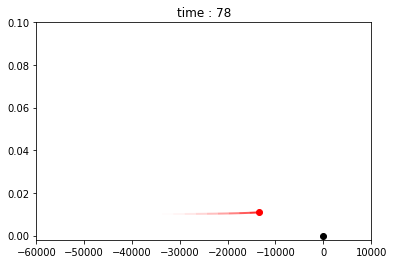

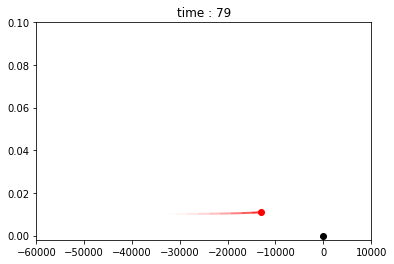

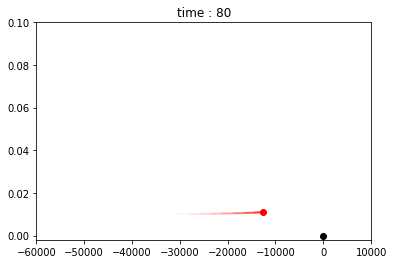

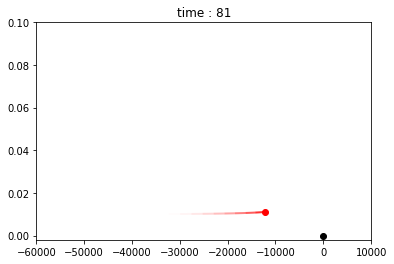

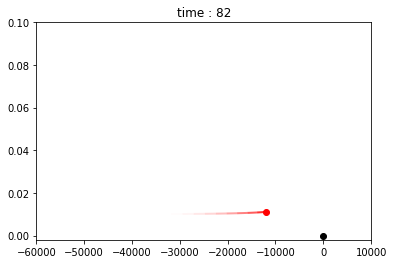

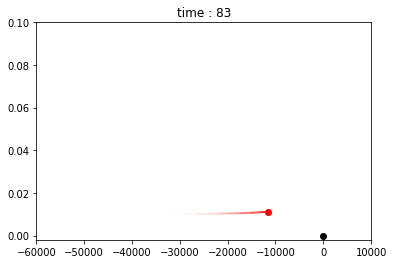

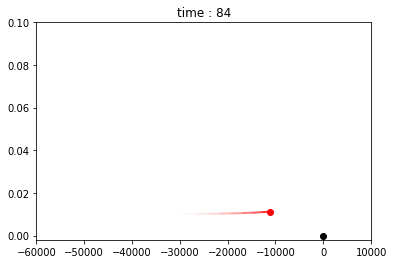

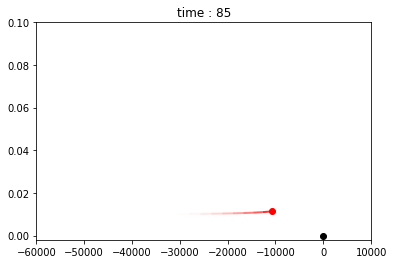

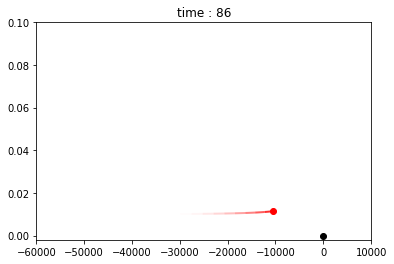

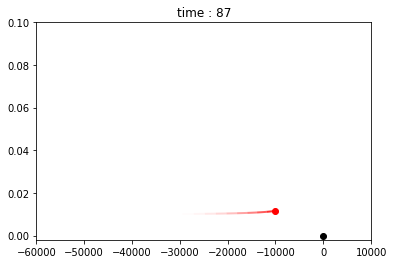

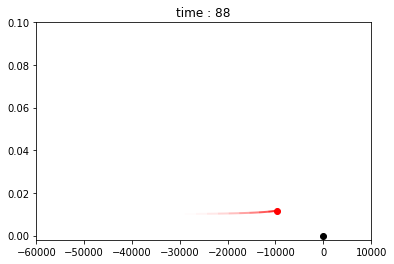

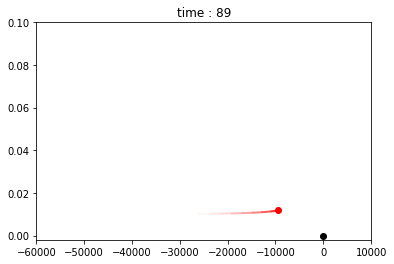

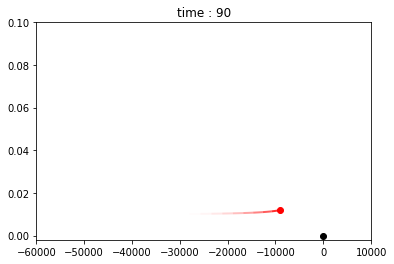

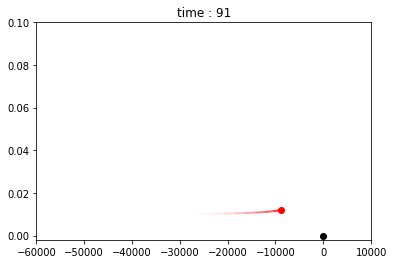

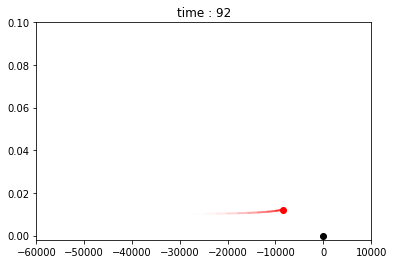

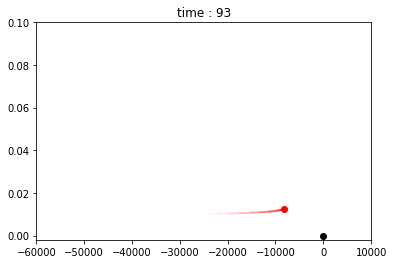

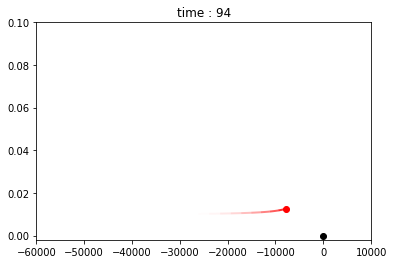

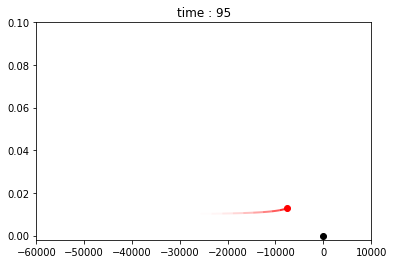

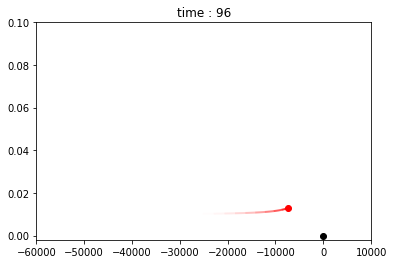

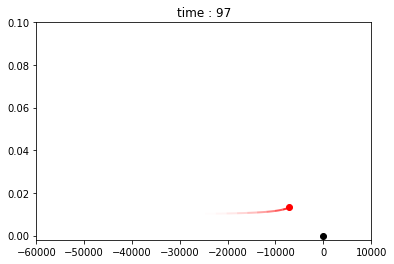

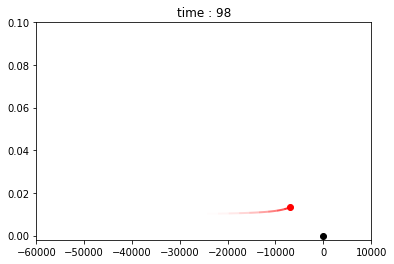

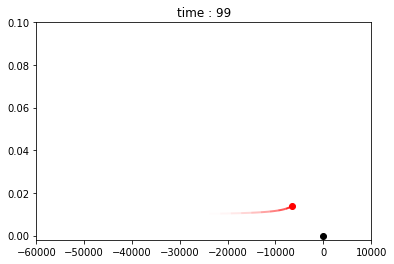

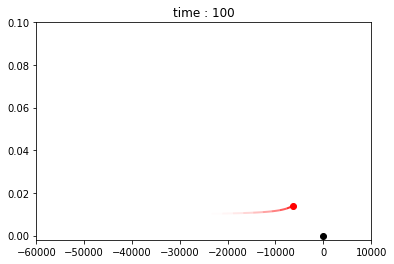

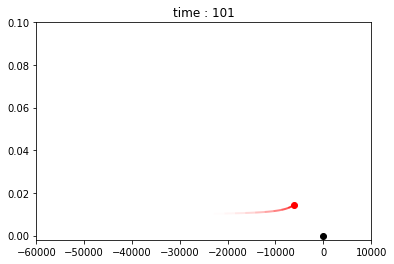

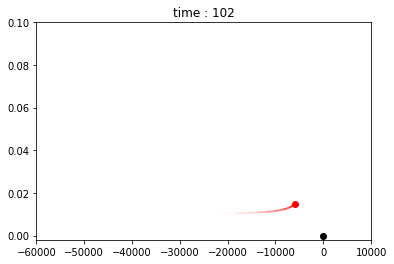

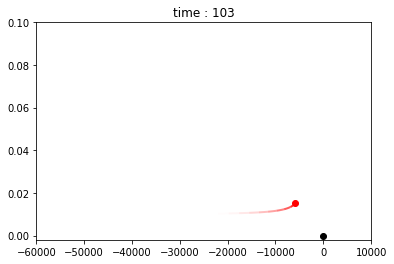

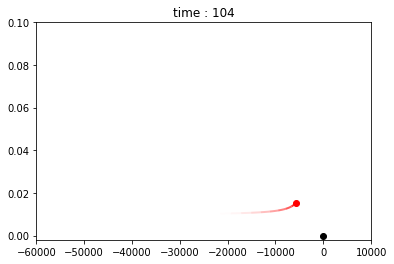

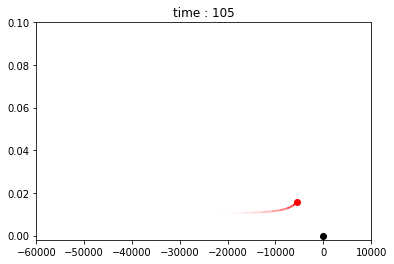

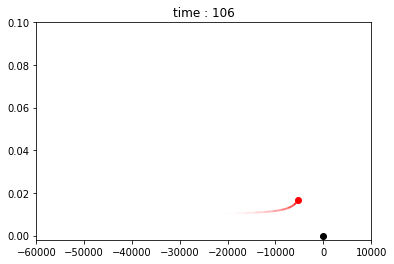

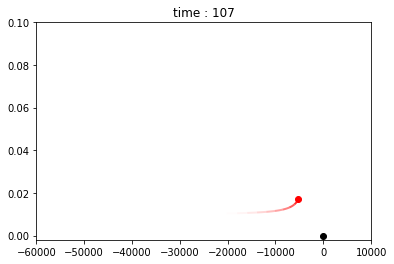

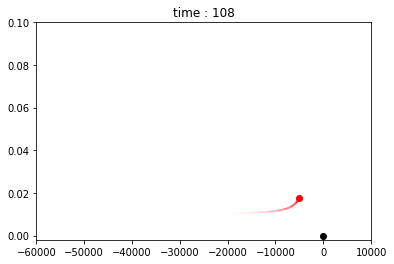

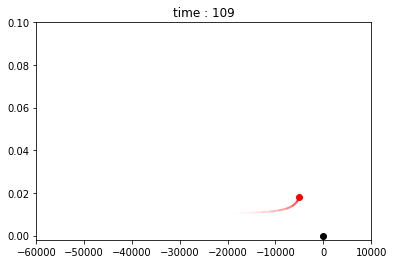

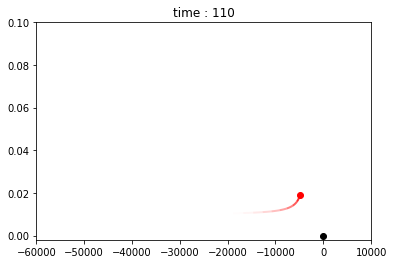

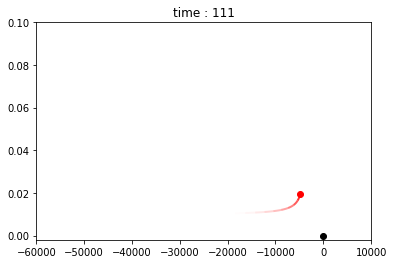

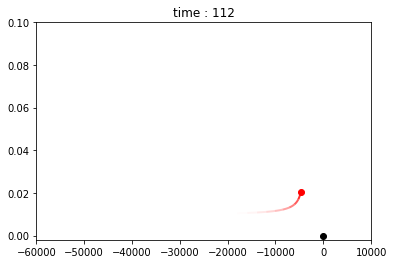

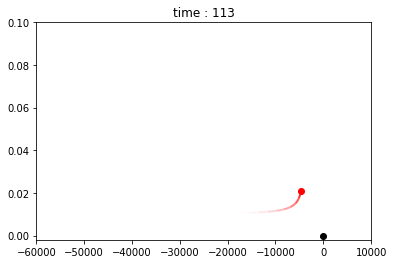

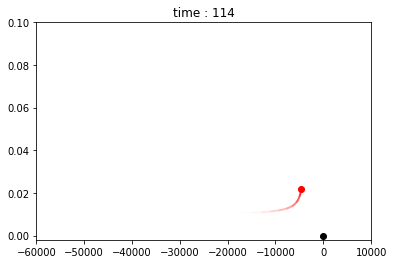

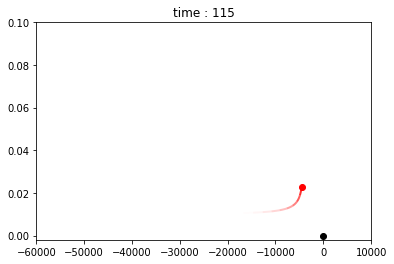

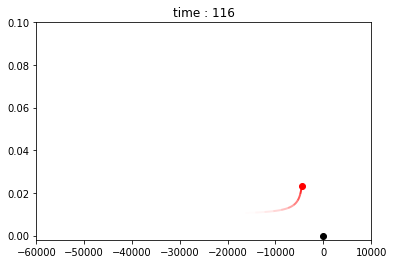

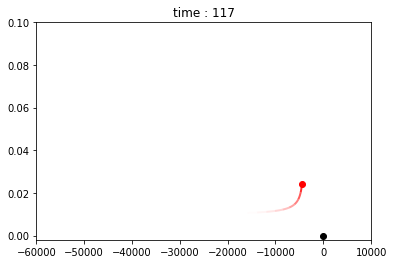

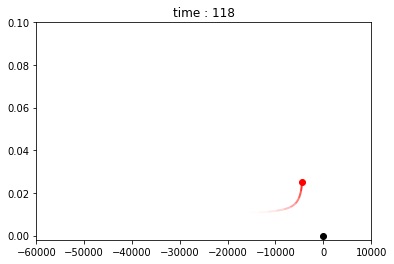

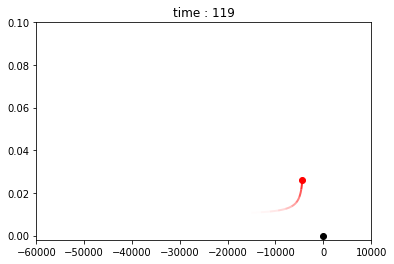

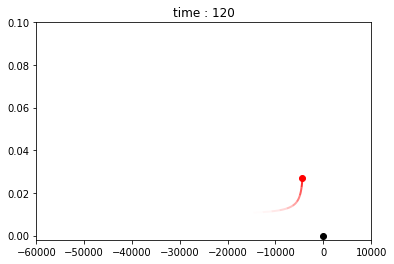

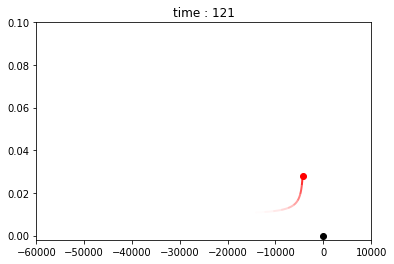

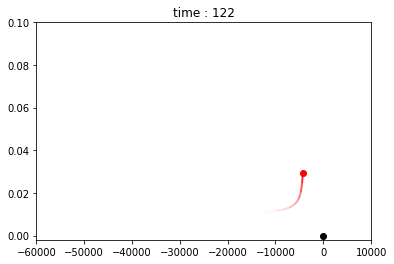

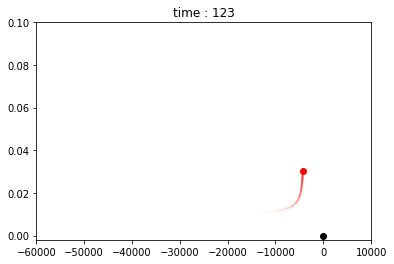

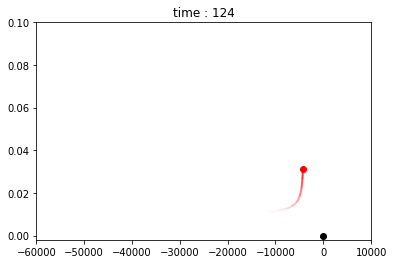

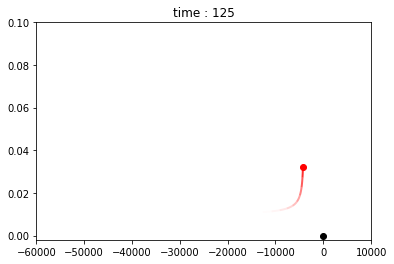

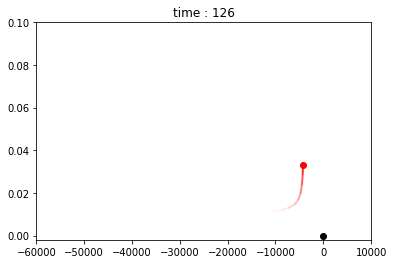

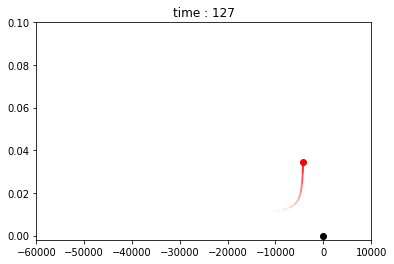

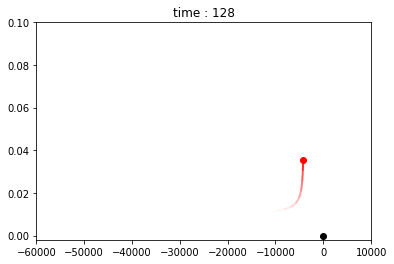

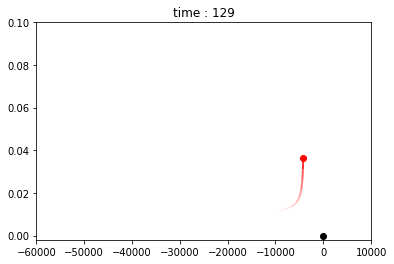

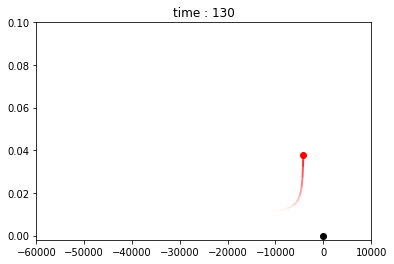

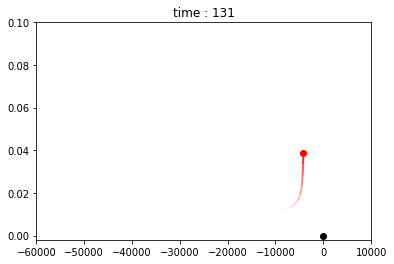

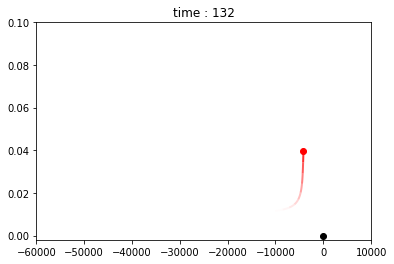

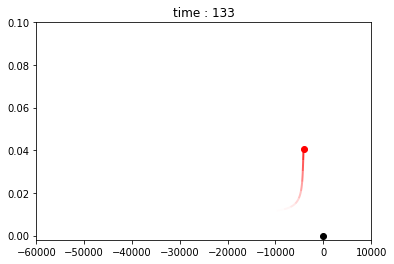

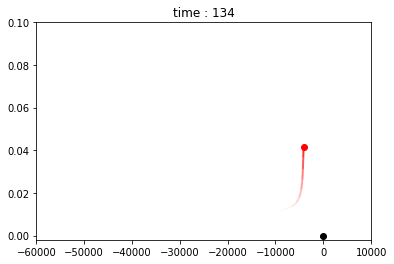

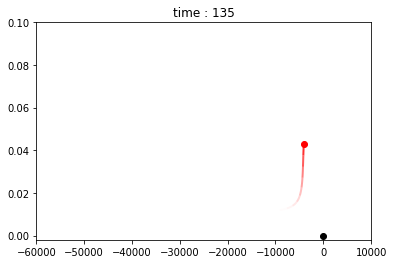

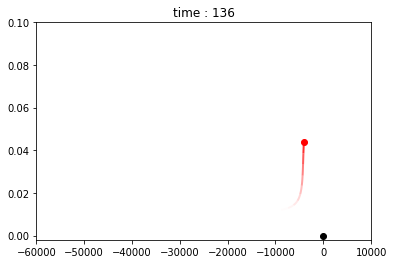

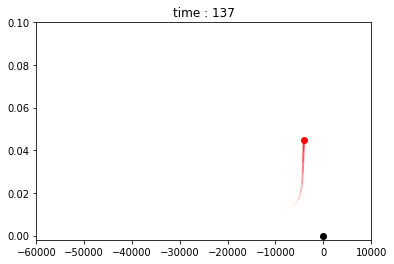

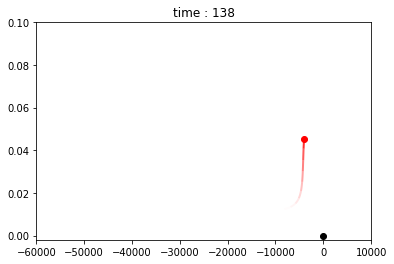

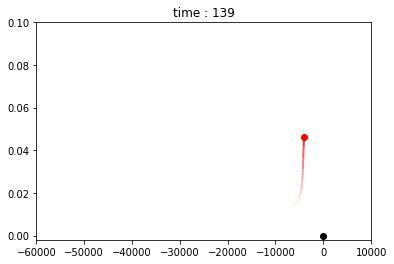

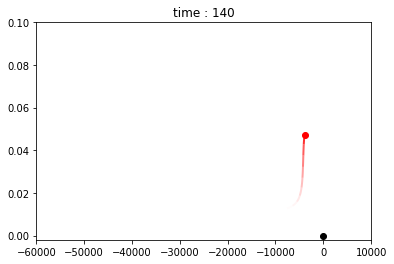

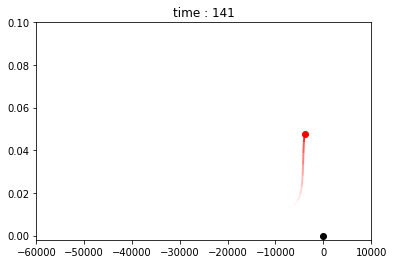

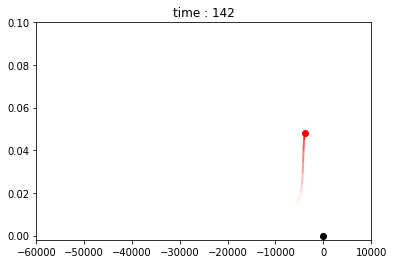

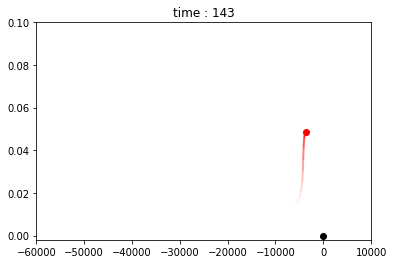

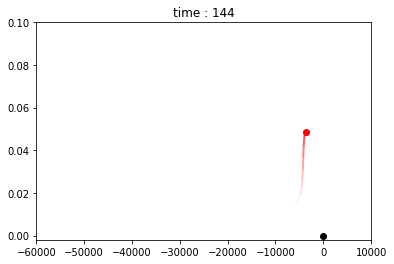

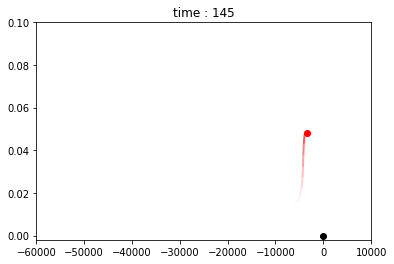

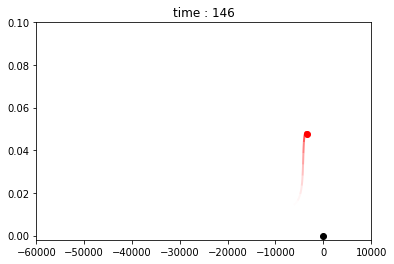

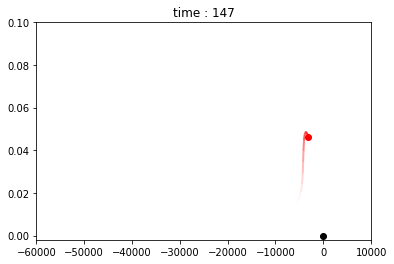

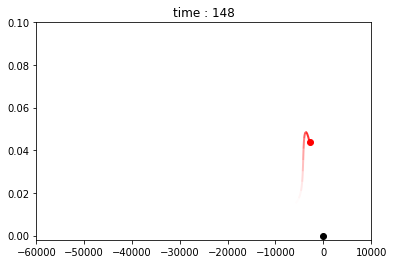

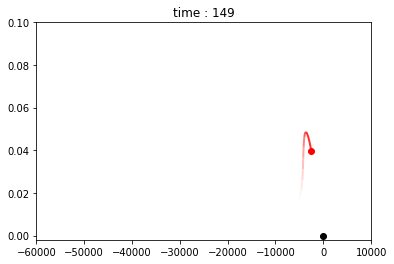

In [252]:
import os
from shutil import rmtree

if os.path.exists('graphs'):  rmtree('graphs')
os.mkdir('graphs')

max_trail = 50
ns = 10
s = max_trail // ns


def make_plot(x_list, y_list, t):
  fig = plt.figure()
  plt.xlim(-60000, 10000)
  # plt.ylim(-0.002, 0.015)
  plt.ylim(-0.002, 0.1)
  plt.title('time : {}'.format(t))
  plt.scatter([0], [0], color='k', zorder=500)
  plt.scatter([x_list[t]], [y_list[t]], color='r', zorder=500)
  
  for j in range(ns):
    tmin = t - (ns - j) * s
    if tmin < 0:  continue
    tmax = tmin + s + 1
    alpha = (j/ns)**2
    plt.plot(x_list[tmin:tmax], y_list[tmin:tmax], color='r', solid_capstyle='butt',
                lw=2, alpha=alpha)
  fig.savefig('graphs/graph_{}'.format(t), dpi=300)


for t in range(0, int(1.5/dt)): # 0초 ~ n초까지 dt 간격으로 위치 표시
  make_plot(field.dot1_x_list, field.dot1_y_list, t)


In [253]:
import os
from PIL import Image
from IPython.display import Image as Img
from IPython.display import display

def generate_gif(path):
    img_list = os.listdir(path)
    img_list = [path + '/' + 'graph_{}'.format(t) + '.png' for t in range(0, int(1.5/dt))]
    print(img_list)
    images = [Image.open(x) for x in img_list]
    
    im = images[0]
    im.save('out.gif', save_all=True, append_images=images[1:],loop=0xff, duration=50)
    # loop 반복 횟수
    # duration 프레임 전환 속도 (500 = 0.5초)
    return Img(url='out.gif')

generate_gif('./graphs')

['./graphs/graph_0.png', './graphs/graph_1.png', './graphs/graph_2.png', './graphs/graph_3.png', './graphs/graph_4.png', './graphs/graph_5.png', './graphs/graph_6.png', './graphs/graph_7.png', './graphs/graph_8.png', './graphs/graph_9.png', './graphs/graph_10.png', './graphs/graph_11.png', './graphs/graph_12.png', './graphs/graph_13.png', './graphs/graph_14.png', './graphs/graph_15.png', './graphs/graph_16.png', './graphs/graph_17.png', './graphs/graph_18.png', './graphs/graph_19.png', './graphs/graph_20.png', './graphs/graph_21.png', './graphs/graph_22.png', './graphs/graph_23.png', './graphs/graph_24.png', './graphs/graph_25.png', './graphs/graph_26.png', './graphs/graph_27.png', './graphs/graph_28.png', './graphs/graph_29.png', './graphs/graph_30.png', './graphs/graph_31.png', './graphs/graph_32.png', './graphs/graph_33.png', './graphs/graph_34.png', './graphs/graph_35.png', './graphs/graph_36.png', './graphs/graph_37.png', './graphs/graph_38.png', './graphs/graph_39.png', './graphs